In [32]:
import os
import json
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import display
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from kaggle.api.kaggle_api_extended import KaggleApi #sometimes throws errors and has to be rerun for some reason

In [33]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.clear_session()

In [34]:
api = KaggleApi()
folder_path = 'Dataset'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    api.dataset_download_files('wanderdust/coin-images', path=folder_path, unzip=True)
else:
    print('Dataset already downloaded')

Dataset already downloaded


In [35]:
num_classes = 211
input_size = 128

In [36]:
with open('Dataset/cat_to_name.json','r') as f:
    coin_data = json.load(f)


In [37]:
image_paths = {'train':[],'validation':[],'test':[]}
labels = {'train':[],'validation':[],'test':[]}
paths = {'train':'Dataset/coins/data/train',
         'validation':'Dataset/coins/data/validation/',
         'test': 'Dataset/coins/data/test/'
         }
for k in ['train', 'validation', 'test']:
    for parent_file_name in os.listdir(paths[k]):
        for file_name in os.listdir(os.path.join(paths[k],parent_file_name)):
            if file_name.endswith(('.jpg','.png','.jpeg')):
                image_paths[k].append(os.path.join(paths[k],parent_file_name,file_name))
                labels[k].append(parent_file_name)

In [38]:
def image_preprocessing(image_path, label = None, num_classes = None, augment = False, flip_h = False, flip_v = False, grey = False):
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, np.float32) 
    image = tf.image.resize(image, [input_size, input_size])
    if label is not None:
        label = tf.one_hot(int(label),num_classes)
    
    if augment:
        if flip_h:
            image = tf.image.flip_left_right(image)
        if flip_v:    
            image = tf.image.flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        if grey:
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.grayscale_to_rgb(image)
          
    return image, label  

In [39]:
dataset = {}


for k in image_paths:

    image_list = image_paths[k]
    label_list = labels[k]
    
    

    tf_dataset = tf.data.Dataset.from_tensor_slices((image_list, label_list))
    
    tf_dataset = tf_dataset.map(lambda image_path, label: image_preprocessing(image_path=image_path, label = label, num_classes= num_classes), 
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if k == 'train':  
        for flip_h in [True, False]:
            for flip_v in [True, False]:
                for grey in [True, False]:
                    tf_augmented_dataset = tf.data.Dataset.from_tensor_slices((image_list, label_list))
                    tf_augmented_dataset = tf_augmented_dataset.map(
                        lambda image_path, label: image_preprocessing(image_path, label, num_classes,
                                                                      augment=True,
                                                                      flip_h=flip_h,
                                                                      flip_v=flip_v,
                                                                      grey=grey),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE
                    )
                    tf_dataset = tf_dataset.concatenate(tf_augmented_dataset)

    tf_dataset = tf_dataset.shuffle(buffer_size=1000, seed = 32).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    
    dataset[k] = tf_dataset


In [40]:
def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # Initial Conv and MaxPool layers
    layer = Conv2D(kernel_size=(7, 7), filters=64, strides=2, padding="same")(input_layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = Activation('leaky_relu')(layer)
    layer = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(layer)
    layer = Dropout(0.5)(layer)
    
    # Residual Block 1
    for i in range(3):
        shortcut = layer
        layer = Conv2D(kernel_size=(1, 1), filters=64, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(3, 3), filters=64, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(1, 1), filters=256, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        
        # Adjust shortcut dimensions if needed
        if shortcut.shape[-1] != layer.shape[-1]:
            shortcut = Conv2D(kernel_size=(1, 1), filters=256, strides=1, padding="same")(shortcut)
            shortcut = BatchNormalization(axis=-1)(shortcut)
        
        layer = Add()([layer, shortcut])
        layer = Activation('leaky_relu')(layer)
    
    # Residual Block 2
    for i in range(4):
        shortcut = layer
        layer = Conv2D(kernel_size=(1, 1), filters=128, strides=2 if i == 0 else 1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(3, 3), filters=128, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(1, 1), filters=512, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        
        # Adjust shortcut dimensions if needed
        if shortcut.shape[-1] != layer.shape[-1]:
            shortcut = Conv2D(kernel_size=(1, 1), filters=512, strides=2 if i == 0 else 1, padding="same")(shortcut)
            shortcut = BatchNormalization(axis=-1)(shortcut)
        
        layer = Add()([layer, shortcut])
        layer = Activation('leaky_relu')(layer)
    
    # Residual Block 3
    for i in range(6):
        shortcut = layer
        layer = Conv2D(kernel_size=(1, 1), filters=256, strides=2 if i == 0 else 1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(3, 3), filters=256, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(1, 1), filters=1024, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        
        # Adjust shortcut dimensions if needed
        if shortcut.shape[-1] != layer.shape[-1]:
            shortcut = Conv2D(kernel_size=(1, 1), filters=1024, strides=2 if i == 0 else 1, padding="same")(shortcut)
            shortcut = BatchNormalization(axis=-1)(shortcut)
        
        layer = Add()([layer, shortcut])
        layer = Activation('leaky_relu')(layer)
    
    # Residual Block 4
    for i in range(3):
        shortcut = layer
        layer = Conv2D(kernel_size=(1, 1), filters=512, strides=2 if i == 0 else 1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(3, 3), filters=512, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('leaky_relu')(layer)
        layer = Conv2D(kernel_size=(1, 1), filters=2048, strides=1, padding="same")(layer)
        layer = BatchNormalization(axis=-1)(layer)
        
        # Adjust shortcut dimensions if needed
        if shortcut.shape[-1] != layer.shape[-1]:
            shortcut = Conv2D(kernel_size=(1, 1), filters=2048, strides=2 if i == 0 else 1, padding="same")(shortcut)
            shortcut = BatchNormalization(axis=-1)(shortcut)
        
        layer = Add()([layer, shortcut])
        layer = Activation('leaky_relu')(layer)
    
    # Global Average Pooling and Output
    layer = GlobalAveragePooling2D()(layer)
    layer = Dropout(0.5)(layer)
    layer = Flatten()(layer)
    output_layer = Dense(num_classes, activation='softmax')(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Compile and Train the Model
model = build_model((input_size, input_size, 3), num_classes)

model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(dataset['train'], validation_data=(dataset['validation']), batch_size=32, epochs=100, callbacks=[early_stopping, lr_scheduler])


Epoch 1/100
1804/1804 [==============================] - 460s 245ms/step - loss: 4.8538 - accuracy: 0.0984 - val_loss: 4.7697 - val_accuracy: 0.1505 - lr: 0.0100
Epoch 2/100
1804/1804 [==============================] - 441s 243ms/step - loss: 2.4144 - accuracy: 0.4596 - val_loss: 2.2660 - val_accuracy: 0.5344 - lr: 0.0100
Epoch 3/100
1804/1804 [==============================] - 444s 245ms/step - loss: 1.1634 - accuracy: 0.7054 - val_loss: 1.6775 - val_accuracy: 0.6872 - lr: 0.0100
Epoch 4/100
1804/1804 [==============================] - 392s 216ms/step - loss: 0.5885 - accuracy: 0.8380 - val_loss: 1.6425 - val_accuracy: 0.7073 - lr: 0.0100
Epoch 5/100
1804/1804 [==============================] - 321s 177ms/step - loss: 0.3128 - accuracy: 0.9110 - val_loss: 1.6180 - val_accuracy: 0.7358 - lr: 0.0100
Epoch 6/100
1804/1804 [==============================] - 321s 177ms/step - loss: 0.1873 - accuracy: 0.9462 - val_loss: 1.6829 - val_accuracy: 0.7263 - lr: 0.0100
Epoch 7/100
1804/1804 [=====

In [41]:
def build_resnet(input_shape,num_classes):
    base_resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape, input_shape, 3))
    x = base_resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)  # Optional dense layer for intermediate features
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)  
    resnet_model = Model(inputs=base_resnet.input, outputs=output_layer)
    return resnet_model

resnet_model = build_resnet(input_size,num_classes)
resnet_model.compile(optimizer='sgd', metrics=['accuracy'], loss='categorical_crossentropy')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

resnet_model.fit(dataset['train'], validation_data=(dataset['validation']),batch_size=32,epochs=100, callbacks=[early_stopping,lr_scheduler])

Epoch 1/100
1804/1804 [==============================] - 459s 246ms/step - loss: 4.1720 - accuracy: 0.1882 - val_loss: 2.4603 - val_accuracy: 0.4917 - lr: 0.0100
Epoch 2/100
1804/1804 [==============================] - 398s 219ms/step - loss: 1.7478 - accuracy: 0.6039 - val_loss: 1.2030 - val_accuracy: 0.7370 - lr: 0.0100
Epoch 3/100
1804/1804 [==============================] - 401s 221ms/step - loss: 0.8046 - accuracy: 0.7981 - val_loss: 1.0070 - val_accuracy: 0.7915 - lr: 0.0100
Epoch 4/100
1804/1804 [==============================] - 392s 216ms/step - loss: 0.4374 - accuracy: 0.8827 - val_loss: 1.0591 - val_accuracy: 0.7986 - lr: 0.0100
Epoch 5/100
1804/1804 [==============================] - 388s 214ms/step - loss: 0.2490 - accuracy: 0.9300 - val_loss: 1.0309 - val_accuracy: 0.8128 - lr: 0.0100
Epoch 6/100
1804/1804 [==============================] - 392s 216ms/step - loss: 0.1648 - accuracy: 0.9524 - val_loss: 1.1474 - val_accuracy: 0.7938 - lr: 0.0100
Epoch 7/100
1804/1804 [=====

In [42]:
cnn_loss, cnn_accuracy = model.evaluate(dataset['test'])
resnet_loss, resnet_accuracy = resnet_model.evaluate(dataset['test'])
print(f'Testing results:\n CNN Loss: {cnn_loss}\n CNN Accuracy: {cnn_accuracy}\n Resnet Loss: {resnet_loss}\n Resnet Accuracy: {resnet_accuracy}\n')
model.save('coin_man(CNN)')
resnet_model.save('coin_man(ResNet)')

27/27 [==============================] - 4s 56ms/step - loss: 0.8316 - accuracy: 0.8081
Testing results:
 CNN Loss: 1.3961411714553833
 CNN Accuracy: 0.741706132888794
 Resnet Loss: 0.8315656781196594
 Resnet Accuracy: 0.8080568909645081



INFO:tensorflow:Assets written to: coin_man(CNN)\assets


INFO:tensorflow:Assets written to: coin_man(CNN)\assets


INFO:tensorflow:Assets written to: coin_man(ResNet)\assets


INFO:tensorflow:Assets written to: coin_man(ResNet)\assets


In [43]:
model = load_model('coin_man(CNN)')
res_net_model = load_model('coin_man(ResNet)')

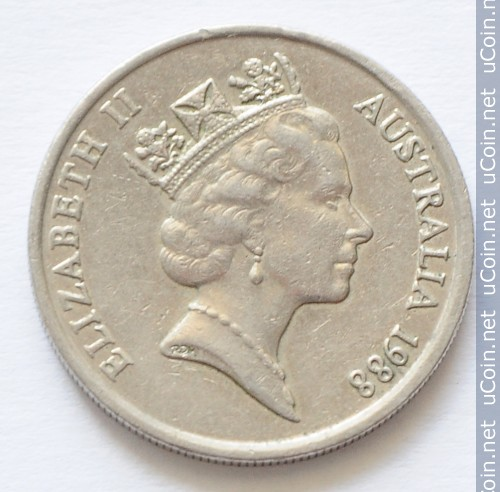

(128, 128, 3)
1/1 [==============================] - 1s 1s/step
CNN Model prediction: 1 Dollar,Australian dollar,australia, ResNet prediction: 2 Dollars,Australian dollar,australia, Actual value: 10 Cents,Australian dollar,australia


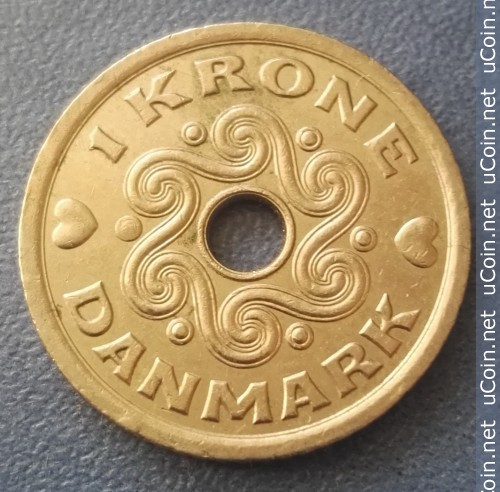

(128, 128, 3)
1/1 [==============================] - 0s 39ms/step
CNN Model prediction: 1 Krone,Danish Krone,denmark, ResNet prediction: 1 Krone,Danish Krone,denmark, Actual value: 1 Krone,Danish Krone,denmark


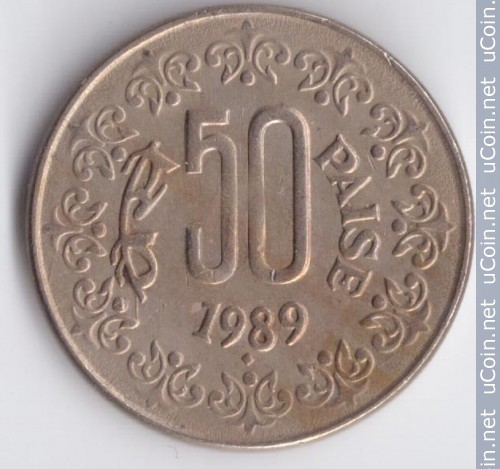

(128, 128, 3)
1/1 [==============================] - 0s 41ms/step
CNN Model prediction: 50 Paise,Indian Rupee,india, ResNet prediction: 50 Paise,Indian Rupee,india, Actual value: 50 Paise,Indian Rupee,india


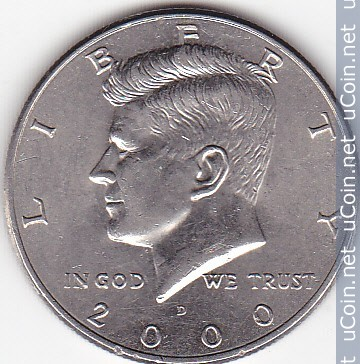

(128, 128, 3)
1/1 [==============================] - 0s 57ms/step
CNN Model prediction: 1 2 Dollar,US Dollar,usa, ResNet prediction: 1 2 Dollar,US Dollar,usa, Actual value: 1 2 Dollar,US Dollar,usa


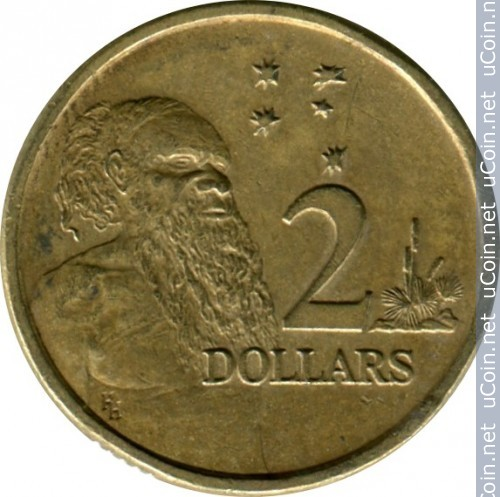

(128, 128, 3)
1/1 [==============================] - 0s 47ms/step
CNN Model prediction: 2 Dollars,Australian dollar,australia, ResNet prediction: 2 Dollars,Australian dollar,australia, Actual value: 2 Dollars,Australian dollar,australia


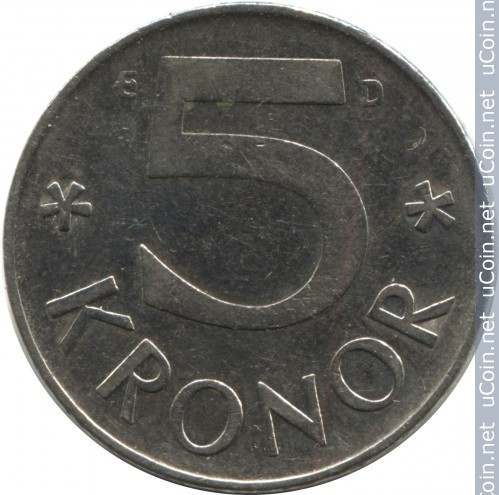

(128, 128, 3)
1/1 [==============================] - 0s 45ms/step
CNN Model prediction: 1 Jiao,Chinese Yuan Renminbi,china, ResNet prediction: 5 Kronor,Swedish Krona,sweden, Actual value: 5 Kronor,Swedish Krona,sweden


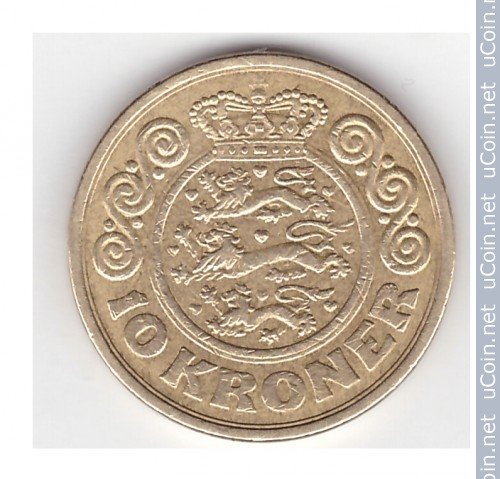

(128, 128, 3)
1/1 [==============================] - 0s 42ms/step
CNN Model prediction: 10 Kroner,Danish Krone,denmark, ResNet prediction: 10 Kroner,Danish Krone,denmark, Actual value: 10 Kroner,Danish Krone,denmark


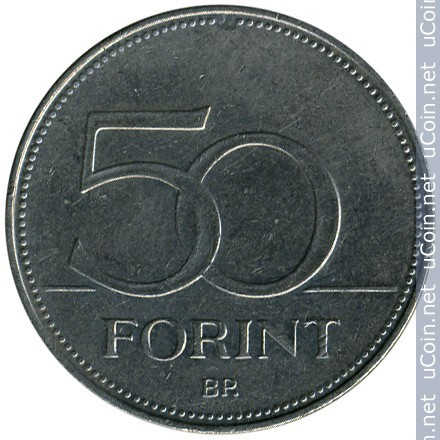

(128, 128, 3)
1/1 [==============================] - 0s 44ms/step
CNN Model prediction: 50 Forint,Hungarian Forint,hungary, ResNet prediction: 50 Forint,Hungarian Forint,hungary, Actual value: 50 Forint,Hungarian Forint,hungary


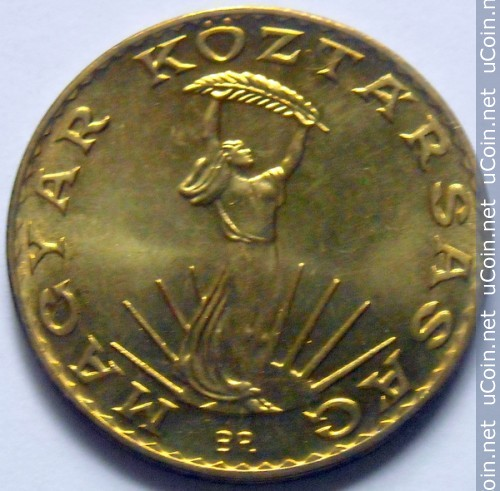

(128, 128, 3)
1/1 [==============================] - 0s 35ms/step
CNN Model prediction: 10 Forint,Hungarian Forint,hungary, ResNet prediction: 10 Forint,Hungarian Forint,hungary, Actual value: 10 Forint,Hungarian Forint,hungary


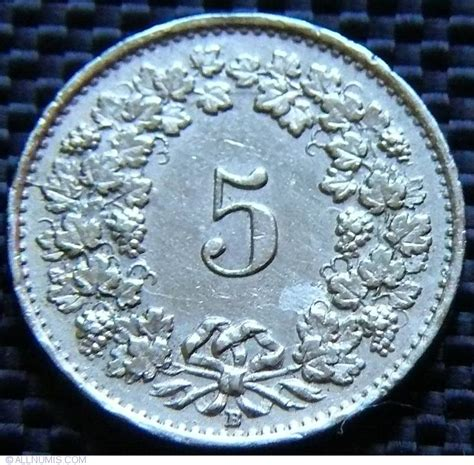

(128, 128, 3)
1/1 [==============================] - 0s 37ms/step
CNN Model prediction: 5 Rappen,Swiss Franc,switzerland, ResNet prediction: 5 Rappen,Swiss Franc,switzerland, Actual value: 5 Rappen,Swiss Franc,switzerland


In [44]:
for i in range(10):
    index = np.random.randint(0,len(image_paths['test']))
    test_case = image_paths['test'][index]
    image = Image.open(test_case)
    display(image)
    test_case  = image_preprocessing(test_case)[0]
    print(test_case.shape)
    test_case = np.expand_dims(test_case, axis=0)
    pred = model.predict(test_case)
    res_pred = resnet_model.predict(test_case)
    predicted_class = np.argmax(pred, axis=-1)[0]
    res_class = np.argmax(res_pred, axis=-1)[0]
    print(f"CNN Model prediction: {coin_data[str(predicted_class)]}, ResNet prediction: {coin_data[str(res_class)]}, Actual value: {coin_data[labels['test'][index]]}")

